## Importação das bibliotecas necessárias

In [1]:
import numpy as np
import pandas as pd
#%matplotlib qt

import matplotlib
matplotlib.use('nbagg')
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

from sklearn.preprocessing import OrdinalEncoder, StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, GridSearchCV, RepeatedStratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.metrics import roc_auc_score, roc_curve, auc, precision_score, recall_score
from sklearn import decomposition
from sklearn.pipeline import Pipeline
from sklearn import set_config
set_config(display="diagram")
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import FunctionTransformer
from sklearn.compose import ColumnTransformer

from xgboost import XGBRFClassifier

C:\Users\ggcs1\anaconda3\lib\site-packages\scipy\__init__.py:138: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.0)
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion} is required for this version of "


In [2]:
df_open = pd.read_csv('air_system_present_year.csv')

In [3]:
df_open.head()

,class,aa_000,ab_000,ac_000,ad_000,ae_000,af_000,ag_000,ag_001,ag_002,...,ee_002,ee_003,ee_004,ee_005,ee_006,ee_007,ee_008,ee_009,ef_000,eg_000
0,neg,60,0,20,12,0,0,0,0,0,...,1098,138,412,654,78,88,0,0,0,0
1,neg,82,0,68,40,0,0,0,0,0,...,1068,276,1620,116,86,462,0,0,0,0
2,neg,66002,2,212,112,0,0,0,0,0,...,495076,380368,440134,269556,1315022,153680,516,0,0,0
3,neg,59816,na,1010,936,0,0,0,0,0,...,540820,243270,483302,485332,431376,210074,281662,3232,0,0
4,neg,1814,na,156,140,0,0,0,0,0,...,7646,4144,18466,49782,3176,482,76,0,0,0


In [4]:
df_open.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16000 entries, 0 to 15999
Columns: 171 entries, class to eg_000
dtypes: int64(1), object(170)
memory usage: 20.9+ MB


In [5]:
# Proporção de veículos que necessitaram de manutenção
pd.value_counts(df_open['class'])

neg    15625
pos      375
Name: class, dtype: int64

In [6]:
pct_pos = 375/16000
print(f'O os resultados positivos correspondem a {pct_pos*100:.2f}% dos registros totais')

O os resultados positivos correspondem a 2.34% dos registros totais


In [7]:
corretivos = 58/375
preventivos = 317/375

print(f'Dos resultados positivos: \nOs corretivos correspondem a {corretivos*100:.2f}\nOs preventivos correspondem a {preventivos*100:.2f}')

Dos resultados positivos: 
Os corretivos correspondem a 15.47
Os preventivos correspondem a 84.53


### Sistema de equações que representa as variáveis do problema entre as vistorias preventivas e corretivas

* Considerando que o custo de manutenção dos sistemas de ar da frota de caminhões, no atual ano o valor corresponde a cerca de $37000;
* O número total de registros de com class = 'pos', isso é, em que foi encontrado um problema no sistema de ar, seja ele na revisão preventiva ou corretiva, foi de 375:

$$
\left\{
\begin{aligned}
&\!\!500*corretivos + 25*preventivos = 37000 \\
&\!\!corretivos - preventivos = 375 \\
\end{aligned}
\right.
\quad\Rightarrow\quad
\begin{pmatrix}
corretivos \\
preventivos \\
\end{pmatrix}
=
\begin{pmatrix}
58 \\
317 \\
\end{pmatrix}
$$

* Os problemas corretivos representam cerca de 15.5% dos casos de manutenção. Logo o objetivo principal será reduzir essa porcentagem, investindo em um número maior revisões preventivas.

### Transformações necessárias para adequação dos dados no o treinamento

1. Substituição dos valores "na" em valores nulos;
2. Transformação das colunas de atributos em float;
3. Conversão dos valores da coluna target em valores binários (0, 1);
4. Filtro para o número máx de valores nulos por coluna: 20% para a proporção de cada coluna;
5. Valores faltantes preenchidos com a mediana de cada coluna, devido a alta variação de valores extremos;
6. Normalização dos valores das colunas, devido a alta variação de valores extremos.

In [8]:
# Função responsável pelas transformações do dataset

def transformar(df):
    # Substitui valores 'na' por valores Nulos de fato
    df = df.replace("na", None)
    # Elimina temporariamente a coluna target da tabela
    col_tg = df.columns.drop('class')
    # Converte todos os valores das colunas em float
    df[col_tg] = df[col_tg].astype(float)
    
    # Declaração e transformação da coluna target em valores binários 0 e 1
    encoder = OrdinalEncoder()
    target = df['class']
    target = pd.DataFrame(target)
    encoder.fit(target)

    # Tabela final já transformada
    df['class'] = encoder.transform(target)

    # Filtro de colunas para 20% de volume de valores nulos
    df = df.dropna(axis=1, thresh=len(df)*0.2)
    # Para as colunas restantes, os valores nulos serão preenchidos com a mediana da mesma
    df = df.fillna(df.median())
    
    # Declaração e aplicação da normalização dos dados das colunas, já que há grande variância entre seus números
    scaler = StandardScaler()
    scaler.fit(df.drop('class', axis=1))
    scaled_data = scaler.transform(df.drop('class', axis=1))
    scaled_data = pd.DataFrame(scaled_data)
    X = scaled_data
    X['class'] = df['class']
    
    return X

In [9]:
df = transformar(df_open)
df.head()

,0,1,2,3,4,5,6,7,8,9,...,159,160,161,162,163,164,165,166,167,class
0,-0.134924,-0.137538,-0.433693,-0.259405,-0.053204,-0.059627,-0.018614,-0.02299,-0.058136,-0.106506,...,-0.379295,-0.369641,-0.337213,-0.295763,-0.215305,-0.267130,-0.159622,-0.018788,-0.016517,0.0
1,-0.134881,-0.137538,-0.433693,-0.238681,-0.053204,-0.059627,-0.018614,-0.02299,-0.058136,-0.109136,...,-0.379057,-0.368683,-0.337643,-0.295757,-0.215074,-0.267130,-0.159622,-0.018788,-0.016517,0.0
2,-0.003962,1.429849,-0.433693,-0.185393,-0.053204,-0.059627,-0.018614,-0.02299,-0.058136,0.086476,...,0.276886,-0.020698,-0.122468,0.806803,-0.120439,-0.266164,-0.159622,-0.018788,-0.016517,0.0
3,-0.016248,-0.137538,-0.433692,0.424463,-0.053204,-0.059627,-0.018614,-0.02299,-0.058136,-0.109136,...,0.040289,0.013559,0.049851,0.065875,-0.085608,0.260531,-0.098624,-0.018788,-0.016517,0.0
4,-0.131441,-0.137538,-0.433693,-0.164670,-0.053204,-0.059627,-0.018614,-0.02299,-0.058136,-0.109136,...,-0.372382,-0.355315,-0.297980,-0.293166,-0.215062,-0.266988,-0.159622,-0.018788,-0.016517,0.0


### Redução de dimensionalidade com o PCA

A técnica escolhida para executar a redução de dimensionalidade da tabela foi o PCA. Reduzir a dimensão da tabela garante que inúmeras colunas desnecessárias sejam "eliminadas", e o mais importante, garante a economia de uso de recursos computacionais.

In [10]:
# Atribuição do PCA e seu random state
pca = PCA(random_state=7)

### Função para gráfico 3D - Análise das métricas 

A função retorna os datapoints do treinamento com fine-funing dos hiperparâmetros ajustados para cada numero de componentes PCA testado. O conjunto ideal de parâmetros é aquele em que o ponto euclidiano (Acurácia, Recall, Precisão) está mais próximo do ponto _(1, 1, 1)_
* O ponto vermelho representa o ponto ótimo, o que possui a menor distância até o ponto _( 1, 1, 1)_
* O ponto marcado como "x" representa o ponto _( 1, 1, 1)_

![Gráfico 3D resultante da função](grafico.png)

In [11]:
def graph_3d(x, y, z):
    
    """x: Acurácia
    y: Recall
    z: Precisão"""
    
    x = np.array(x)
    y = np.array(y)
    z = np.array(z)
    
    # Cálculo da distância de cada ponto até o ponto (1,1,1)
    dist = np.sqrt((x-1)**2 + (y-1)**2 + (z-1)**2)

    # Índice do ponto mais próximo de (1,1,1)
    closest_idx = np.argmin(dist)

    # Lista de cores para cada ponto
    colors = ['blue']*len(x)
    colors[closest_idx] = 'red'  # o ponto mais próximo será destacado em vermelho
        
    # Criação do gráfico
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(x, y, z, c=colors)
    ax.scatter(1, 1, 1, c='green', marker='x')

    # Configuração dos eixos
    ax.set_xlabel('Accuracy')
    ax.set_ylabel('Recall')
    ax.set_zlabel('Precision')

    # Exibição do gráfico
    plt.show()

### Função treino e finetunning dos hiperparâmetros - Regressão Logística
Dada a necessidade de redução de dimensionalidade do dataset, o número de componentes da função de PCA também é tratada como um hiperparâmetro.
Entre outros hiperparâmetros ajustados dentro do modelo por meio de cross validation estão:
* _Solver_
* _Penalty_
* _C_

A função retorna os melhores valores ajustados para cada numero de componentes PCA testado. O conjunto ideal de parâmetros é aquele em que o ponto euclidiano (Acurácia, Recall, Precisão) está mais próximo do ponto (1, 1, 1)

In [12]:
## Vou trocar a ordem de algumas coisas aqui nessa celula

def tuning_logreg(df):
        
    """Retorno traz em ordem: solver, penalty, C, valor do componente PCA e o threshold"""
    #Listas pontuações
    rec = []
    auc_ = []
    accu = []
    #Listas parâmetros
    slvr = []
    penal = []
    c_final = []
    comp = []
    thrs_final = []
    
    # Atribução das variáveis que serão dividias
    X = df.iloc[:,1:].copy() # Apenas colunas de atributos
    y = df['class'].copy()

    for c in range(2, 11):
        print('-'*100)
        print(f'Component PCA: {c}')
        metrics_dict = {}
        #split estratatificado entre a tabela de treino/val test
        X_train_val, X_test_val, y_train_val, y_test = train_test_split(X, y, stratify=y, test_size=0.20, random_state = 7)
        #split strat train and val
        X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, stratify=y_train_val, test_size=0.20, random_state = 7)
        
        # Atribuição dos componentes para a realização do PCA
        pca.n_components = c
        pca.fit(X_train)
        X_pca = pca.transform(X_train)
        X_train = pd.DataFrame(X_pca)
        pca.fit(X_val)
        X_val_pca = pca.transform(X_val)
        X_val = pd.DataFrame(X_val_pca)
        
        #Parâmtetros
        solvers = ['lbfgs', 'liblinear']
        penalty = ['l1', 'l2']
        c_values = [5, 1.0, 0.1, 0.01, 0.001]
        
        #logreg
        logisticRegr = LogisticRegression(random_state = 7)

        
        #Grid para CrossVal
        grid = dict(solver=solvers,penalty=penalty,C=c_values)
        cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=4, random_state=1)
        grid_search = GridSearchCV(estimator=logisticRegr, 
                                   param_grid=grid, 
                                   n_jobs=-1, 
                                   cv=cv, 
                                   scoring='accuracy',
                                   error_score=0)
        grid_result = grid_search.fit(X_train, y_train)
        score = grid_result.best_score_
        params = grid_result.best_params_
        print(f'Parâmetros {params}')
        
        #Parâmetros resultado para colocar no modelo final
        pen=params['penalty'],
        solver=params['solver'],
        C=params['C']
        
        #logreg
        logisticRegr = LogisticRegression(random_state=7,
                                        penalty=params['penalty'],
                                        solver=params['solver'],
                                        C=params['C'])
        #FitLogreg
        logisticRegr.fit(X_train, y_train)
        fpr, tpr, thresholds = roc_curve(y_val, logisticRegr.predict_proba(X_val)[:,1])
        roc_auc = auc(fpr, tpr)
        
        
        # Calculando o threshold ótimo
        dists = np.sqrt(fpr**2 + (1-tpr)**2)
        optimal_idx = np.argmin(dists)
        optimal_threshold = thresholds[optimal_idx]
        optimal_tpr = tpr[optimal_idx]
        optimal_fpr = fpr[optimal_idx]
        
        # Predizendo valores
        predictions = logisticRegr.predict_proba(X_val)[:,1]
        predictions = pd.DataFrame(predictions)
        predictions[1] = 0
        thr_atl = optimal_threshold - 0.1*optimal_threshold
        for i in range(len(predictions)):
            if predictions.iloc[i,0] > thr_atl:
                predictions.iloc[i,1] = 1
            else:
                predictions.iloc[i,1] = 0
        predictions = predictions[1]
        
        # Métricas de confusion matrix
        cm = metrics.confusion_matrix(y_val, predictions)
        tn, fp, fn, tp = cm[0][0], cm[0][1], cm[1][0], cm[1][1]
        precision = tp / (tp + fp)
        recall = tp / (tp + fn)
        total = tn + fp + fn + tp
        accuracy = (tn + tp) / total
        print(cm)
        
        # Imprimir métricas
        print(f"Precision: {precision:.4f}")
        print(f"Recall: {recall:.4f}")
        print(f"AUC: {roc_auc:.4f}")
        print(f'Accuracy: {accuracy:.4f}')
        rec.append(recall)
        auc_.append(precision)
        accu.append(accuracy)
        
        # armazena as métricas no dicionário
        metrics_dict[(solver, pen, C, c, thr_atl)] = {'precision': precision, 'recall': recall}
        slvr.append(solver)
        penal.append(pen)
        c_final.append(C)
        comp.append(c)
        thrs_final.append(thr_atl)
        
    print('')
    print('='*100)
    opt = min(zip(rec, accu, auc_), key=lambda p: ((p[0]-1)**2 + (p[1]-1)**2 + (p[2]-1)**2)**0.5)
    rec_opt, accu_opt, prec_opt = opt
    index_opt = accu.index(accu_opt)
    print(f'Ótimo => Recall: {rec_opt:.4f}, Accuracy: {accu_opt:.4f}, Precision: {prec_opt:.4f}')
    
    # Calcula a distância Euclidiana do ponto ótimo até o ponto (1, 1, 1)
    dist_opt = np.linalg.norm(np.array([rec_opt, accu_opt, prec_opt]) - np.array([1, 1, 1]))
    # Imprime o valor da distância calculada
    print(f"A distância do ponto ótimo até o ponto (1, 1, 1) é {dist_opt}")
    
    results = list(zip(slvr, penal, c_final, comp, thrs_final))
    graph_3d(accu, rec, auc_)

    return results[index_opt][0], results[index_opt][1], results[index_opt][2], results[index_opt][3], results[index_opt][4]


----------------------------------------------------------------------------------------------------
Component PCA: 2
Parâmetros {'C': 0.01, 'penalty': 'l2', 'solver': 'liblinear'}
[[2301  199]
 [   4   56]]
Precision: 0.2196
Recall: 0.9333
AUC: 0.9608
Accuracy: 0.9207
----------------------------------------------------------------------------------------------------
Component PCA: 3
Parâmetros {'C': 0.01, 'penalty': 'l2', 'solver': 'liblinear'}
[[2301  199]
 [   4   56]]
Precision: 0.2196
Recall: 0.9333
AUC: 0.9609
Accuracy: 0.9207
----------------------------------------------------------------------------------------------------
Component PCA: 4
Parâmetros {'C': 0.01, 'penalty': 'l2', 'solver': 'liblinear'}
[[2313  187]
 [   4   56]]
Precision: 0.2305
Recall: 0.9333
AUC: 0.9672
Accuracy: 0.9254
----------------------------------------------------------------------------------------------------
Component PCA: 5
Parâmetros {'C': 0.001, 'penalty': 'l2', 'solver': 'lbfgs'}
[[2319  181]

<IPython.core.display.Javascript object>


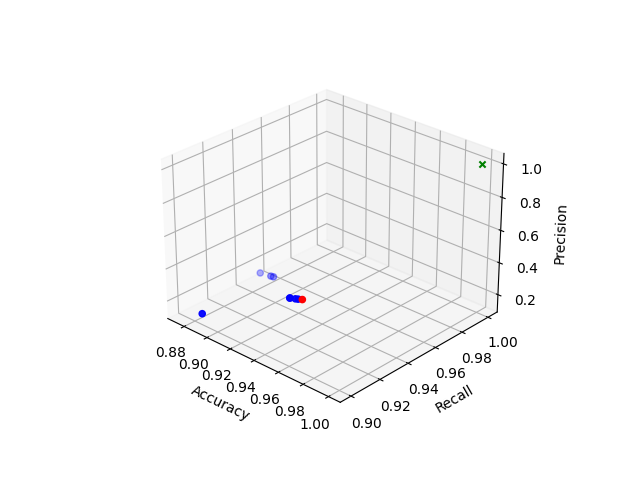

(('lbfgs',), ('l2',), 0.001, 6, 0.013464987539260932)

In [13]:
tuning_logreg(df)

## Função treino e finetunning dos hiperparâmetros - Random Forest
Dada a necessidade de redução de dimensionalidade do dataset, o número de componentes da função de PCA também é tratada como um hiperparâmetro.
Entre outros hiperparâmetros ajustados dentro do modelo por meio de cross validation estão:
* _Learning Rate_
* _N\_Estimators_
* _Max\_Depth_

A função retorna os melhores valores ajustados para cada numero de componentes PCA testado. O cojunto ideal de parâmetros é aquele em que o ponto euclidiano (Acurácia, Recall, Precisão) está mais próximo do ponto (1, 1, 1)

In [14]:
def tuning_randomforest(df):
    #Listas pontuações
    rec = []
    auc_ = []
    accu = []
    l_rt = []
    n_est = []
    mx_dp = []
    comp = []
    thrs_final = []
    rec = []
    auc_ = []
    
    # Atribução das variáveis que serão dividias
    X = df.iloc[:,1:].copy() # Apenas colunas de atributos
    y = df['class'].copy()

    for c in range(2, 11):
        print('-'*100)
        print(f'Component PCA: {c}')
        metrics_dict = {}
        #split estratatificado entre a tabela de treino/val test
        X_train_val, X_test_val, y_train_val, y_test = train_test_split(X, y, stratify=y, test_size=0.20, random_state = 7)
        #split strat train and val
        X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, stratify=y_train_val, test_size=0.20, random_state = 7)
        
        # Atribuição dos componentes para a realização do PCA
        pca.n_components = c
        pca.fit(X_train)
        X_pca = pca.transform(X_train)
        X_train = pd.DataFrame(X_pca)
        pca.fit(X_val)
        X_val_pca = pca.transform(X_val)
        X_val = pd.DataFrame(X_val_pca)
        #logreg
        model = XGBRFClassifier(random_state = 7)

        # define grid search
        grid = {'learning_rate': [0.01, 0.05, 0.1],
                    'n_estimators': [50, 100, 200],
                    'max_depth': [3, 5, 7]}

        
        cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
        grid_search = GridSearchCV(estimator=model, param_grid= grid, n_jobs=-1, cv=cv, scoring='accuracy',error_score=0)
        grid_result = grid_search.fit(X_train, y_train)
        score = grid_result.best_score_
        params = grid_result.best_params_
        
        
        #logreg
        model = XGBRFClassifier(random_state=7, 
                                learning_rate=params['learning_rate'], 
                                n_estimators=params['n_estimators'],
                                max_depth=params['max_depth'])
        model.fit(X_train, y_train)
        
        fpr, tpr, thresholds = roc_curve(y_val, model.predict_proba(X_val)[:,1])
        roc_auc = auc(fpr, tpr)
        
        # Encontrando o threshold ótimo
        dists = np.sqrt(fpr**2 + (1-tpr)**2)
        optimal_idx = np.argmin(dists)
        optimal_threshold = thresholds[optimal_idx]
        optimal_tpr = tpr[optimal_idx]
        optimal_fpr = fpr[optimal_idx]
        
        #pred
        predictions = model.predict_proba(X_val)[:,1]
        predictions = pd.DataFrame(predictions)
        predictions[1] = 0
        
        #threshold
        thresh = optimal_threshold
        for i in range(len(predictions)):
            if predictions.iloc[i,0] > thresh:
                predictions.iloc[i,1] = 1
            else:
                predictions.iloc[i,1] = 0
        predictions = predictions[1]
        
        cm = metrics.confusion_matrix(y_val, predictions)
        print(cm)
        tn, fp, fn, tp = cm[0][0], cm[0][1], cm[1][0], cm[1][1]
        precision = tp / (tp + fp)
        recall = tp / (tp + fn)
        total = tn + fp + fn + tp
        accuracy = (tn + tp) / total    
        
        # Imprimir métricas
        print(f"Precision: {precision:.4f}")
        print(f"Recall: {recall:.4f}")
        print(f"AUC: {roc_auc:.4f}")
        print(f'Accuracy: {accuracy:.4f}')
        rec.append(recall)
        auc_.append(precision)
        accu.append(accuracy)
        
        l_rt.append(params['learning_rate'])
        n_est.append(params['n_estimators'])
        mx_dp.append(params['max_depth'])
        comp.append(c)
        thrs_final.append(thresh)
    
    print('')
    print('='*100)
    opt = min(zip(rec, accu, auc_), key=lambda p: ((p[0]-1)**2 + (p[1]-1)**2 + (p[2]-1)**2)**0.5)
    rec_opt, accu_opt, prec_opt = opt
    index_opt = accu.index(accu_opt)
    print(f'Ótimo => Recall: {rec_opt}, Accuracy: {accu_opt}, Precision: {prec_opt}')
    
    # Calcula a distância Euclidiana do ponto ótimo até o ponto (1, 1, 1)
    dist_opt = np.linalg.norm(np.array([rec_opt, accu_opt, prec_opt]) - np.array([1, 1, 1]))
    # Imprime o valor da distância calculada
    print(f"A distância do ponto ótimo até o ponto (1, 1, 1) é {dist_opt}")
    
    results = list(zip(l_rt, n_est, mx_dp, comp, thrs_final))
    graph_3d(accu, rec, auc_)
    
    return results[index_opt][0], results[index_opt][1], results[index_opt][2], results[index_opt][3], results[index_opt][4]
    

----------------------------------------------------------------------------------------------------
Component PCA: 2
[[2234  266]
 [   6   54]]
Precision: 0.1688
Recall: 0.9000
AUC: 0.9345
Accuracy: 0.8938
----------------------------------------------------------------------------------------------------
Component PCA: 3
[[2217  283]
 [   4   56]]
Precision: 0.1652
Recall: 0.9333
AUC: 0.9443
Accuracy: 0.8879
----------------------------------------------------------------------------------------------------
Component PCA: 4
[[2204  296]
 [   4   56]]
Precision: 0.1591
Recall: 0.9333
AUC: 0.9509
Accuracy: 0.8828
----------------------------------------------------------------------------------------------------
Component PCA: 5
[[2392  108]
 [  11   49]]
Precision: 0.3121
Recall: 0.8167
AUC: 0.9423
Accuracy: 0.9535
----------------------------------------------------------------------------------------------------
Component PCA: 6
[[2162  338]
 [   8   52]]
Precision: 0.1333
Recall: 0

<IPython.core.display.Javascript object>


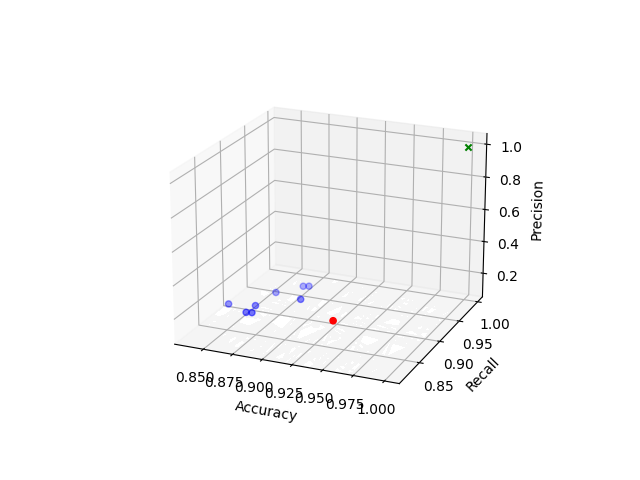

(0.01, 50, 7, 5, 0.49620527)

In [15]:
tuning_randomforest(df)

## Avaliando os resultados dos treinamentos e os pontos de otimização coletados

O modelo de *Logistic Regression* retornou os seguintes parâmetros:
* **Recall**: 0.9333
* **Accuracy**: 0.9313
* **Precision**: 0.2456

O modelo de *Random Forest* retornou os seguites parâmetros:
* **Recall**: 0.8166
* **Accuracy**: 0.9535
* **Precision**: 0.3121

Por mais que a *accuracy* e a *precision* do modelo de *random forest* tenham se comportado melhor em relação ao modelo de *logistic regression*, o ultimo foi escolhido como modelo por conta da pontuação de seu *recall*. 
Como o objetivo principal do problema é reduzir os gastos com manutenções corretivas, isso é, o número de falso negativos *FN*, a avaliação do valor do *recall* deve ter um peso maior nessa decisão. E também é possível concluir que o modelo de *random forest* possui maior *accuracy* por conta do número de verdadeiros positivos *TN* classificados.

## Estabelecendo o modelo treinado e implementar a solução dentro de um pipeline do Scikit-Learn

Para dar inicio ao processo de transformações dentro das pipelines, foi criada a função _transforma()_ que executa as transformações específicas necessárias para adequação dos dados.

In [16]:
# Para utilização no pipeline dos dados
# Função responsável pelas transformações do dataset

def transforma(df):
    # Substitui valores 'na' por valores Nulos de fato
    df = df.replace("na", None)
    # Elimina temporariamente a coluna target da tabela
    #col_tg = df.columns.drop('class')
    # Converte todos os valores das colunas em float
    df = df.astype(float)

    # Filtro de colunas para 20% de volume de valores nulos
    df = df.dropna(axis=1, thresh=len(df)*0.2)
    # Para as colunas restantes, os valores nulos serão preenchidos com a mediana da mesma
    df = df.fillna(df.median())
    
    # Declaração e aplicação da normalização dos dados das colunas, já que há grande variância entre seus números
    scaler = StandardScaler()
    scaler.fit(df)
    scaled_data = scaler.transform(df)
    scaled_data = pd.DataFrame(scaled_data)
    X = scaled_data
    
    return X

## Criação da pipeline final do modelo

A utilização e implementação de pipelines garante a redução de tarefas sucessivas até chegar ao ponto da predição dos valores. São efetuadas as transformações necessárias para que o dataset se adeque ao que foi proposto e a aplicação do modelo de classificação.

* O modelo escolhido foi o de *Logistic Regression* com as seguintes configurações:

| Parâmetro        | Valor          |
| ---------------- | -------------- |
| Solver           | 'lbfgs'        |
| Penalty          | 'l2'           |
| C                | 0.001          |

* O número de componentes do PCA foi: _6_
* O threshold encontrado para ajustar os dados ao problema foi de: _0.013464987539260932_



In [17]:
from sklearn.compose import make_column_transformer

In [18]:
# Cria uma lista com o nome de todas as colunas, exceto "class"
all_cols = df_open.columns.tolist()
del_target = ["class"]
lista_cols = list(set(all_cols) - set(del_target))


# Processamento da tabela
col_process = Pipeline(steps=[("transforma_col", FunctionTransformer(transforma)),
                             ("PCA", PCA(random_state=7, n_components=6))])

# Pipeline completa do modelo
model = Pipeline(steps=[("transforma", col_process),
                        ("modelo", LogisticRegression(random_state=7, 
                                    penalty='l2', 
                                    solver='lbfgs',
                                    C=0.001))])


In [19]:
model

Pipeline(steps=[('transforma',
                 Pipeline(steps=[('transforma_col',
                                  FunctionTransformer(func=<function transforma at 0x00000262003035E0>)),
                                 ('PCA',
                                  PCA(n_components=6, random_state=7))])),
                ('modelo', LogisticRegression(C=0.001, random_state=7))])

## Implementação do modelo e cálculo da acurácia com o test set

Uma vez calculado o threshold, ele deve ser implementado na função _accuracy_data()_ a fim de garantir o filtro estabelecido no treinamento. Além disso, no estágio de produção, o modelo deve seguir o mesmo conceito ao utilizar o limiar de probabilidades.

In [20]:
# Atribução das variáveis que serão dividias
X = df_open.iloc[:,1:].copy() # Apenas colunas de atributos
y = df_open['class'].copy()
#split estratatificado entre a tabela de treino e testr
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state = 7)

In [21]:
model.fit(X_train, y_train)

Pipeline(steps=[('transforma',
                 Pipeline(steps=[('transforma_col',
                                  FunctionTransformer(func=<function transforma at 0x00000262003035E0>)),
                                 ('PCA',
                                  PCA(n_components=6, random_state=7))])),
                ('modelo', LogisticRegression(C=0.001, random_state=7))])

In [22]:
def accuracy_data(X_teste, y_teste, thresh):
    
    predictions = model.predict_proba(X_teste)[:,1]
    predictions = pd.DataFrame(predictions)
    predictions[1] = 0
    
    # Declaração e transformação da coluna target em valores binários 0 e 1
    encoder = OrdinalEncoder()
    target = y_teste
    target = pd.DataFrame(target)
    encoder.fit(target)

    # Tabela final já transformada
    y_teste = encoder.transform(target)

    for i in range(len(predictions)):
        if predictions.iloc[i,0] > thresh:
            predictions.iloc[i,1] = 1
        else:
            predictions.iloc[i,1] = 0
    predictions = predictions[1]

    cm = metrics.confusion_matrix(y_teste, predictions)
    tn, fp, fn, tp = cm[0][0], cm[0][1], cm[1][0], cm[1][1]
    accuracy = (tn + tp) / (tn + fp + fn + tp)

    #Confusion Matrix
    plt.figure(figsize=(5,5))
    sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
    plt.ylabel('Actual label');
    plt.xlabel('Predicted label');
    all_sample_title = f'Accuracy Score: {accuracy:.4f}'
    plt.title(all_sample_title, size = 15)
    plt.show()

    corre = 500*fn
    prev = 25*tp
    nada = 10*fp
    custo = corre + prev + nada

    total = tn + fp + fn + tp
    problema = total*pct_pos
    corroriginal = (problema * corretivos)*500
    prevoriginal = (problema * preventivos)*25
    custooriginal = corroriginal + prevoriginal
    pct_corr = fn/(fn+tp)
    print(f'Custo total de manuntenção será de ${custo}')
    print(f'Custo em uma situação normal: ${custooriginal:.2f}\nEconomia de: ${custooriginal - custo:.2f} ') 
    print(f'ROI: %{((custooriginal - custo)/custooriginal)*100:.2f}')

<IPython.core.display.Javascript object>


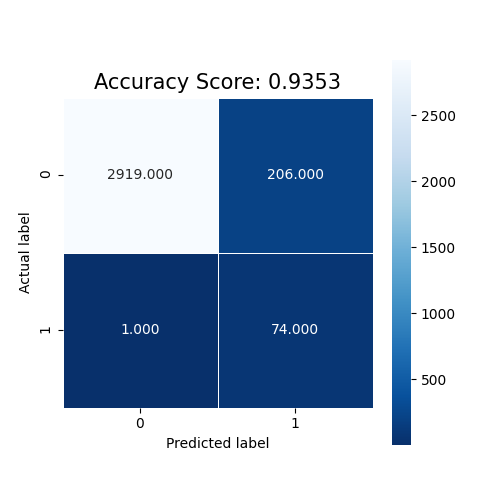

Custo total de manuntenção será de $4410
Custo em uma situação normal: $7385.00
Economia de: $2975.00 
ROI: %40.28


In [25]:
accuracy_data(X_test, y_test, 0.013464987539260932)

In [24]:
import pickle

# Salvando o modelo final
with open('opt-system.pkl', 'wb') as file:
    pickle.dump(model, file)